# Earthquake Prediction

#### Table of Contents
0. Setup
1. Data Analysis
2. Data Preparation
3. Model Training
4. Model Evaluation

In [16]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import preprocessing, model_selection, linear_model

## 0. Setup

In [17]:
filepath = './data/database.csv'

## 1. Data Analysis

In [18]:
df = pd.read_csv(filepath)
df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [19]:
df.describe()

,Latitude,Longitude,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square
count,23412.000000,23412.000000,23412.000000,4461.000000,7097.000000,23412.000000,327.000000,2564.000000,7299.000000,1604.000000,1156.000000,17352.000000
mean,1.679033,39.639961,70.767911,4.993115,275.364098,5.882531,0.071820,48.944618,44.163532,3.992660,7.662759,1.022784
std,30.113183,125.511959,122.651898,4.875184,162.141631,0.423066,0.051466,62.943106,32.141486,5.377262,10.430396,0.188545
min,-77.080000,-179.997000,-1.100000,0.000000,0.000000,5.500000,0.000000,0.000000,0.000000,0.004505,0.085000,0.000000
25%,-18.653000,-76.349750,14.522500,1.800000,146.000000,5.600000,0.046000,10.000000,24.100000,0.968750,5.300000,0.900000
50%,-3.568500,103.982000,33.000000,3.500000,255.000000,5.700000,0.059000,28.000000,36.000000,2.319500,6.700000,1.000000
75%,26.190750,145.026250,54.000000,6.300000,384.000000,6.000000,0.075500,66.000000,54.000000,4.724500,8.100000,1.130000
max,86.005000,179.998000,700.000000,91.295000,934.000000,9.100000,0.410000,821.000000,360.000000,37.874000,99.000000,3.440000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

In [21]:
df.isnull().sum()

Date                              0
Time                              0
Latitude                          0
Longitude                         0
Type                              0
Depth                             0
Depth Error                   18951
Depth Seismic Stations        16315
Magnitude                         0
Magnitude Type                    3
Magnitude Error               23085
Magnitude Seismic Stations    20848
Azimuthal Gap                 16113
Horizontal Distance           21808
Horizontal Error              22256
Root Mean Square               6060
ID                                0
Source                            0
Location Source                   0
Magnitude Source                  0
Status                            0
dtype: int64

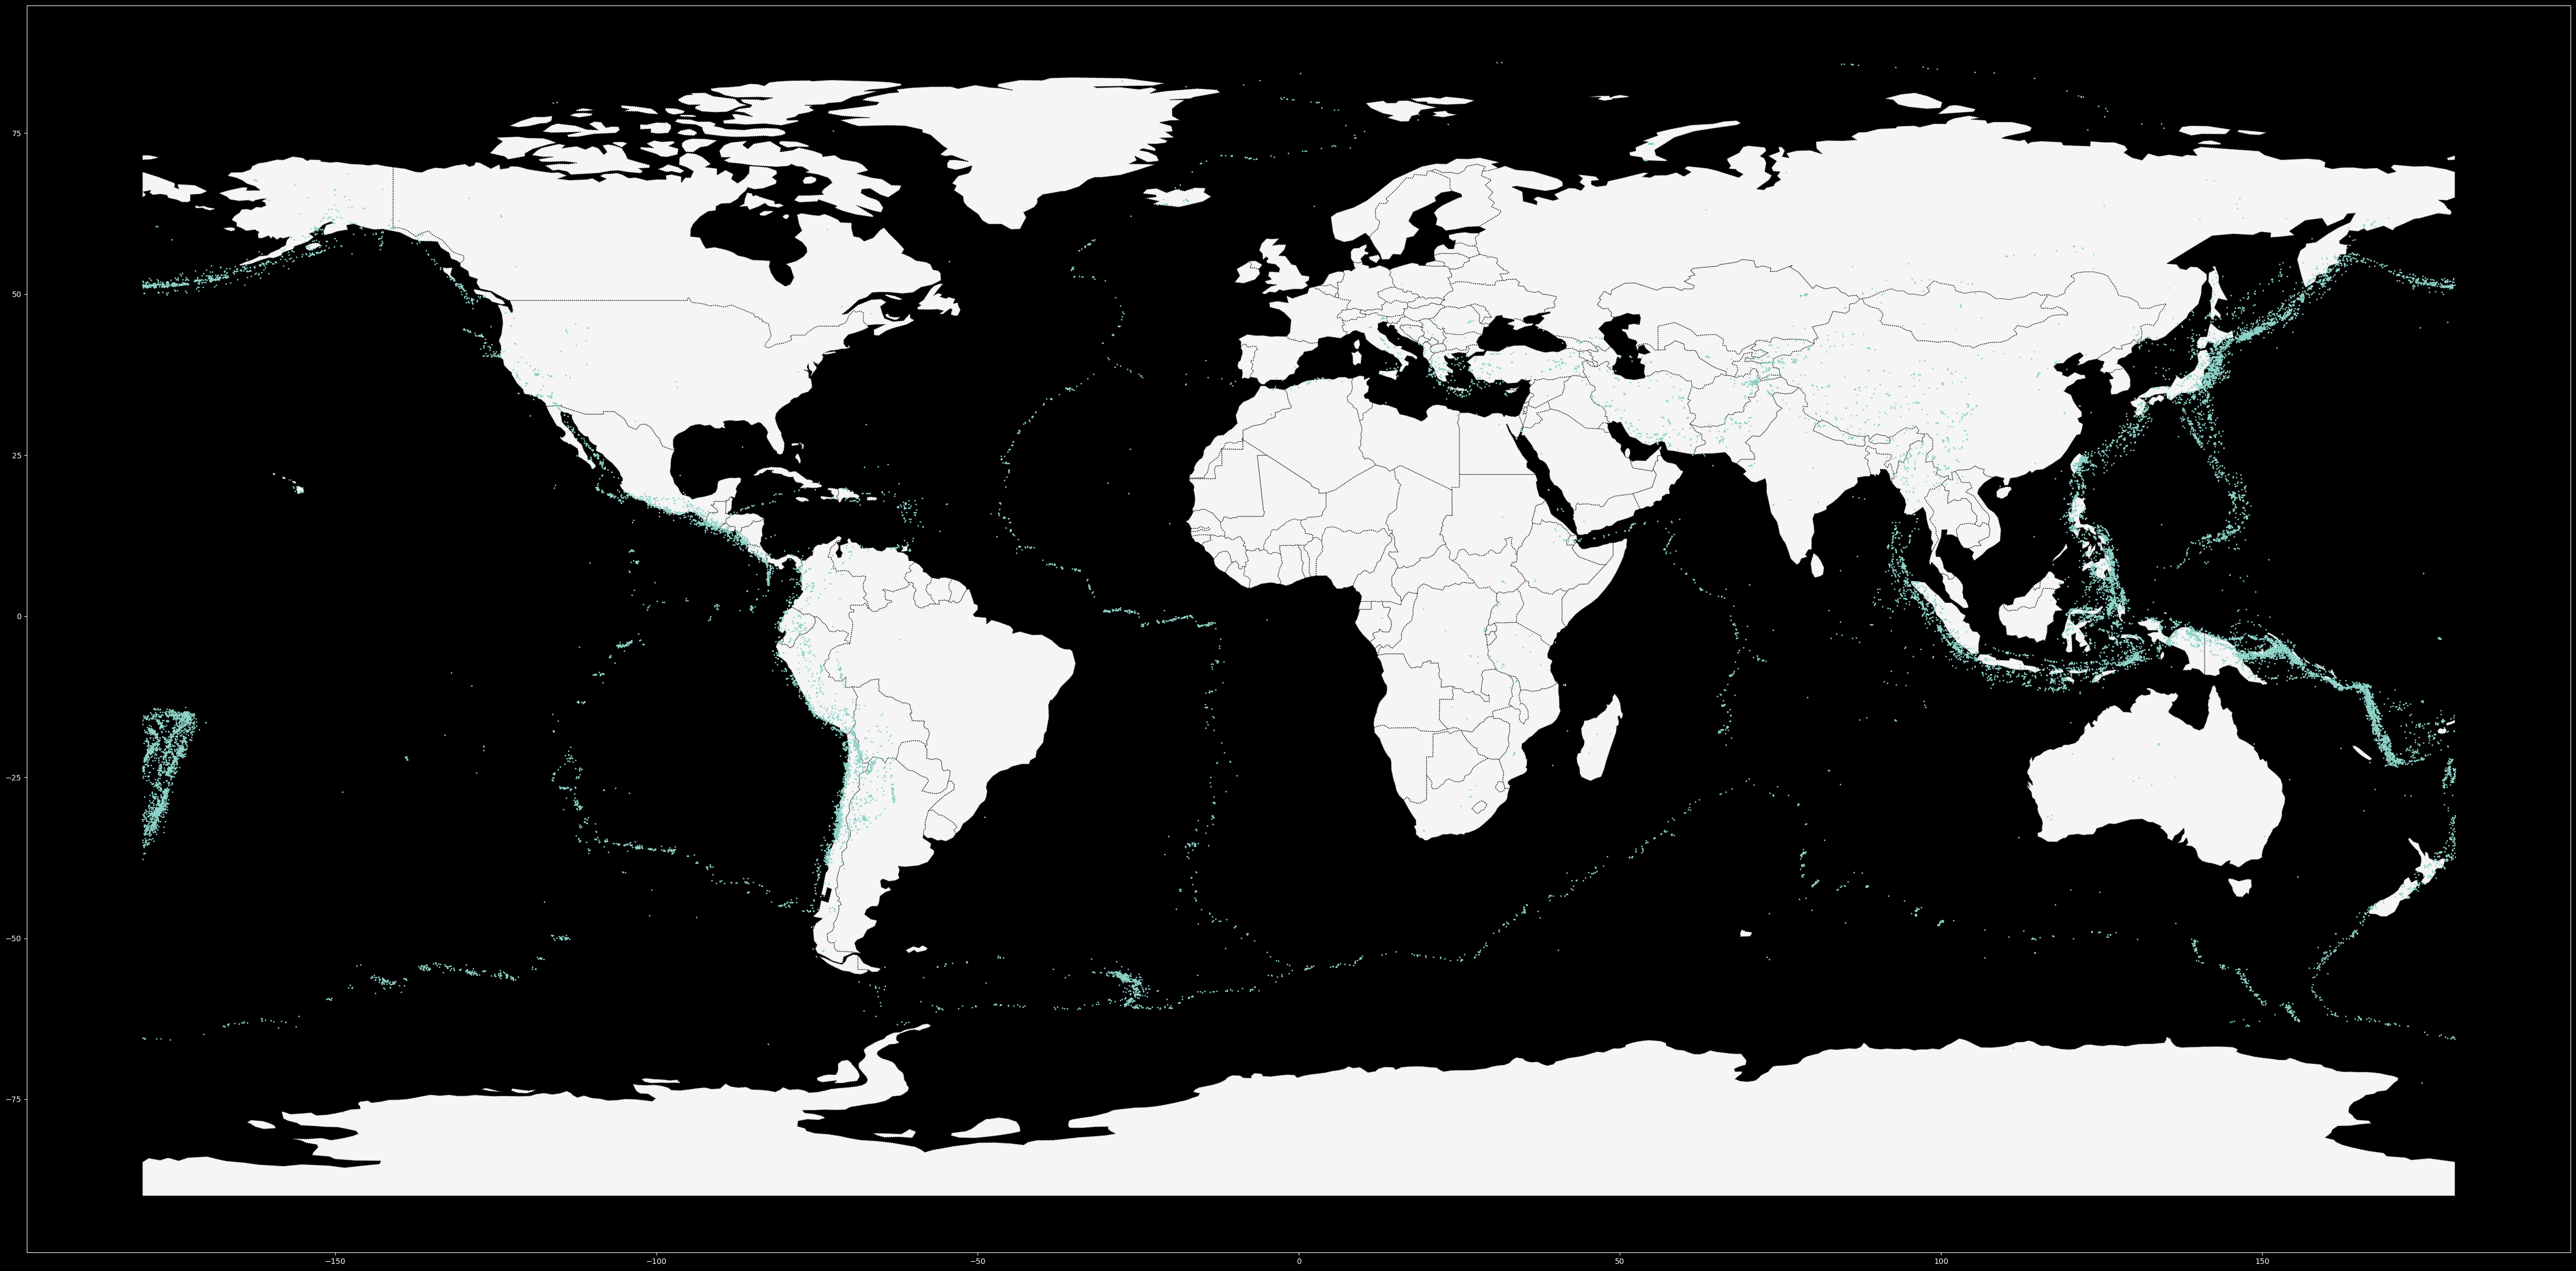

In [22]:
earthquakes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']))
earthquakes.crs = 'EPSG:4326'

world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)

ax = world.plot(figsize=(60, 60), color='whitesmoke', linestyle=':', edgecolor='black')
earthquakes.to_crs(epsg=4326).plot(markersize=1, ax=ax)
plt.show()

In [23]:
print(f'Min magnitude: {df["Magnitude"].min()}')
print(f'Max magnitude: {df["Magnitude"].max()}')

Min magnitude: 5.5
Max magnitude: 9.1


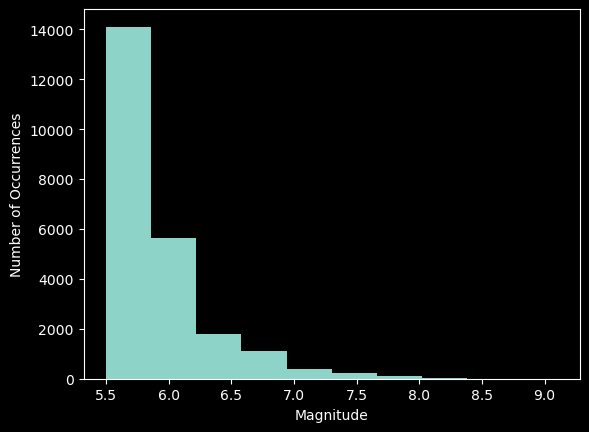

In [24]:
plt.hist(df['Magnitude'])
plt.xlabel('Magnitude')
plt.ylabel('Number of Occurrences')
plt.show()

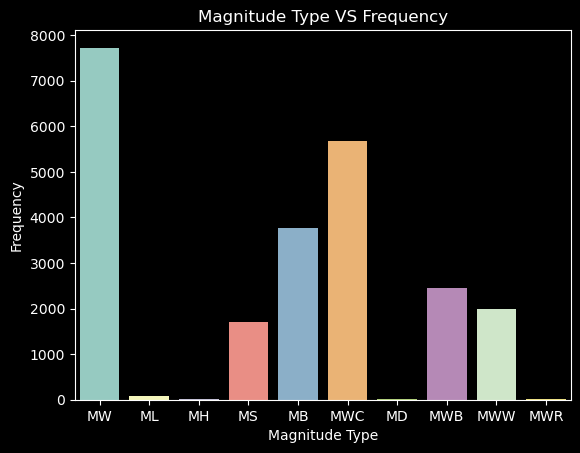

local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)


In [25]:
sns.countplot(data=df, x='Magnitude Type')
plt.ylabel('Frequency')
plt.title('Magnitude Type VS Frequency')
plt.show()

print('local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)')

In [26]:
df.loc[df['Magnitude'] >= 8, 'Class'] = 'Disastrous'
df.loc[(df['Magnitude'] >= 7) & (df['Magnitude'] < 7.9), 'Class'] = 'Major'
df.loc[(df['Magnitude'] >= 6) & (df['Magnitude'] < 6.9), 'Class'] = 'Strong'
df.loc[(df['Magnitude'] >= 5.5) & (df['Magnitude'] < 5.9), 'Class'] = 'Moderate'

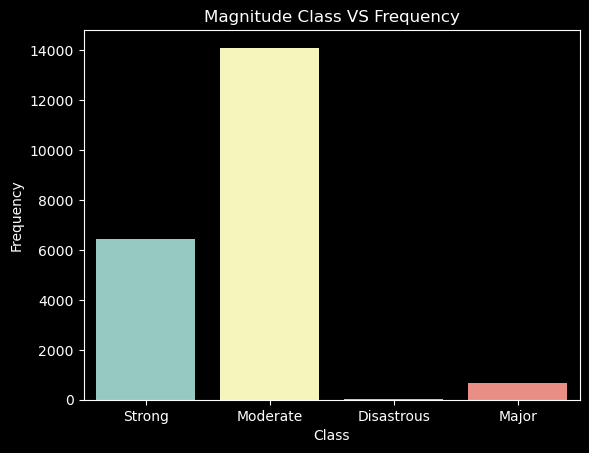

In [27]:
sns.countplot(data=df, x='Class')
plt.ylabel('Frequency')
plt.title('Magnitude Class VS Frequency')
plt.show()

## 2. Data Preparation

## 3. Model Training

In [ ]:
features = []

In [ ]:
df_train = df
df_test = df
df_validation = df

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df_train[features],
    df_train['mag_outcome'], 
    test_size=0.3, 
    random_state=42,
)